# Tracking Objects in Video with Particle Filters

Computer vision has made rapid progress in the last few years, thanks to improvements in training data and algorithms, as well as the availability of cheap GPUs and abundant labeled training datasets.

One of the primary computer vision tasks is object tracking. Object tracking is used in the vast majority of applications such as video surveillance, car tracking, people detection, and tracking, etc. We will use a particle filter to track a moving object. 

Particle filters are powerful and efficient solutions to problems in robotics, artificial intelligence, and even finance.

## Table of Content:
1. Introduction to Particle Filter
2. Loading & Displaying video frames using OpenCV
3. Initializing a Particle Filter
4. Moving Particles According to Their Velocity State
5. Prevent Particles from Falling Off the Edges
6. Measure Each Particle's Quality
7. Assign Weights to the Particles
8. Resample Particles According to Their Weights
9. Fuzz the Particles

## 1. Introduction to Particle Filter
A particle filter is a  generic algorithm for function optimization where the solution search space is searched using particles (sampling). So what does this mean? In our case, each particle incorporates tests on whether how it is likely that the object is at the position where the particle is. After the particles have been evaluated, the weights are assigned according to how good the particles are. Then the good particles are multiplied and the bad particles are removed through the re-sampling process.

The next particle generation then predicts where the object might be. Then this generation is evaluated, and the cycle repeats.
Opposed to the Kalman filter the particle filter can model non-linear object motion because the motion model should not be written as a state transition matrix like in the Discrete Kalman filter. 

Moreover, the particle filter is fairly easy to understand, but there is a negative thing: the performance of the filter depends on the particle number where the higher number of particles will lead to a better estimate, but it is more costly. Nevertheless, the particle filter is largely used for generic function optimization including object tracking. The figure below shows the two main steps of the particle filter: predict and correct.

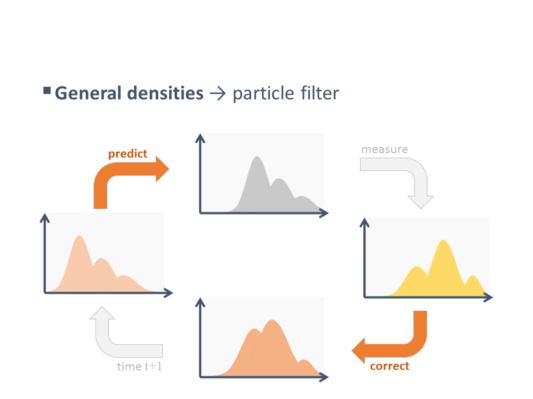

The cycle of a particle filter starts with the general probability densities. First, the filter predicts the next state from the provided state transition (e.g. motion model), then if applicable, the noisy measurement information is incorporated in the correction phase and the cycle is repeated after that.

## 1. Load video frames from file

Let's first import the NumPy math library and the OpenCV computer vision library as they will be used extensively throughout this project. Then we set the random seed so that every time we run the code, we get consistent results.

In [1]:
import numpy as np
import cv2
from IPython.display import clear_output, Image, display, HTML
import ipywidgets as widgets
import threading
import numpy as np

# Repeatability
np.random.seed(0)

In [2]:
VFILENAME = "Man.mp4"

frame_height = 720
frame_width = 1280


We can now load the video frames and display them using OpenCV using the code below:

In [ ]:
import cv2
import numpy as np


# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture('walking.mp4')

# Check if camera opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")
 
# Read until video is completed
while(cap.isOpened()):
  # Capture frame-by-frame
  ret, frame = cap.read()

  if ret == True:
    # Display the resulting frame
    cv2.imshow('Frame',frame)
 
    # Press Q on keyboard to  exit
    if cv2.waitKey(30) & 0xFF == ord('q'):
      break
 
  # Break the loop
  else: 
    break
 
# When everything done, release the video capture object
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()

In the code above we first call a function from OpenCV called VideoCapture which will return a video capture object. And while the video is opened, we want to read the frames. So we’re going to call the read method of this video object, and it’s going to return, like, a status flag and then the frame, which is actually an array of pixel color values.

As long as this flag is valid, we’re going to yield the frame. So this turns that the function into a Python generator that we’re going to call over and over again, and it’s going to keep looping and yielding frames. And if the status is not good, we break out of the loop and release the resources and yield None. Then we will display each frame consecutively for 3o ms and the loop will break if the frame has finished or if you press the q key.



Since we will be using the frame values in different functions as will be seen shortly, it is better to create a function that takes the video path and return the value for each frame:



In [3]:
def get_frames(filename):
    video = cv2.VideoCapture(filename)
    while video.isOpened():
        ret, frame = video.read()
        if ret:
            yield frame 
        else:
            break
    video.release()        
    yield None

Finally, let's create a display function to display the particles and the tracked particle. So the first thing we want to do is check if there are any particles to display. And if so, we’re going to iterate through them and we’re going to use their values as pixel coordinates. So if you want to do that, we’ll have to actually cast them to an integer type. Next, we draw these particles as a tiny circle on top of our video frame. We can use OpenCV’s circle function, hand it the video frame, and the circle center and the radius of one, and then we’ll set the color.

Every time we use OpenCV, the color convention is BGR instead of RGB. So we’ll go with green this time and set a really small curve thickness of one pixel. So that takes care of the particles.

Next, if we get a location for the particle we are trying to track throughout the video. We want to draw a nice circle there. So the location is actually going to be an (x,y) tuple by itself so we can use it directly. And we’ll go with a slightly larger circle, 15 pixels, and go with red this time and a curve thickness of 5 pixels. So next we want to actually display the video frame. There’s an image show function from OpenCV.



In [4]:
def display(frame, particles, location):
    if len(particles)> 0:
        for i in range(NUM_PARTICLES):
            x = int(particles[i,0])
            y = int(particles[i,1])
            cv2.circle(frame, (x,y), 1 , (0,255,0) ,1)
    
    if len(location) > 0:
        cv2.circle(frame,location,15,(0,0,255),5)
    
    cv2.imshow('frame', frame)
    #stop the video if pressing q button
    if cv2.waitKey(30) & 0xFF == ord('q'):
        return True 

    return False

### 3. Initializing a Particle Filter

To initialize the particles that we will show at the top of the video we need to estimate the state of the target, meaning its position and velocity within the video frames. At the beginning of the video, we don’t know that state. All we know is that the position should lie within the frame somewhere and the velocity could be in any direction but not moving too, too fast.

We are going to express our estimate of the target state with a set of particles. Each particle has its own position and velocity. Since we have no information yet about the target, our particles will be scattered uniformly in the frame and they’ll have random velocities.

We can start by initializing the number of particles to 5000 particles and the initial velocity range to be a pixel per frame. Then we will create the particle array. It will be filled with random numbers it will have one row per particle and four columns. The first two will be the coordinates of the particles and the last two will be their velocity. The first two columns will have values between zero and the length and the height of the frame.

The velocity will take the initialized value of 0.5 and we will center it to zero so as to have the possibility to move in both directions. We’re going to decrement that by half the velocity range. And what that will do is shift the velocities down so that everything is centered around zero. You’ll notice that the particles are spread out uniformly at random. Each row here represents one particle and the first two columns that are in the range of hundreds, here they are the x and y position, and then we have the velocity components, which are smaller than one.



In [23]:
NUM_PARTICLES = 500
VEL_RANGE = 0.5

def initialize_particles():
    particles = np.random.rand(NUM_PARTICLES,4)
    particles = particles * np.array((frame_width,frame_height, VEL_RANGE,VEL_RANGE))
    particles[:,2:4] -= VEL_RANGE/2.0
    return particles

We will display the video using the code below:

In [7]:
location =[]
particles = initialize_particles()


for frame in get_frames(VFILENAME):
    if frame is None: break
    terminate = display(frame, particles, location)
    if terminate:
        break

cv2.destroyAllWindows()      

## 4. Moving Particles According to Their Velocity State


You might have noticed during video playback that the particles were not moving, even though they have a velocity. The reason for that is we are not updating their position according to the velocities.

We can solve this with the code below. We are going to increment the particle's x-coordinates with the x-direction velocity component that’s in the third column ( index 2). And we do something similar for the y. So let’s run the code that will prevent particles from falling off the edge of the video frame and see if it worked.



In [7]:
def apply_velocity(particles):
    particles[:,0] += particles[:,2]
    particles[:,1] += particles[:,3]

    return particles

Now you see are particles are moving according to their velocity using the code below:


In [11]:
location = []
particles = initialize_particles()


for frame in get_frames(VFILENAME):
    if frame is None: break
    particles = apply_velocity(particles)

    terminate = display(frame, particles, location)
    if terminate:
        break

cv2.destroyAllWindows()      

## 5. Prevent Particles from Falling Off the Edges

Next, we will add some logic to keep them from falling off the edge of the frame and also decide which particles are more relevant than others. We will do this by putting a limit on the particles’ (x,y) coordinates. To do so we will loop over all the particles and add upper and lower boundaries on both x and y coordinates. The new value for the x coordinate will be the minimum of Width— 1 and the current value. For the y coordinate will be the minimum of Height— 1 and the current value.

By doing this we will prevent the x value from getting greater than WIDTH — 1 and we subtract one as the frame coordinates are zero-based. So if you had a frame with 100 pixels width, you would want the coordinate to go from 0 to 99. Then we are going to place a lower bound on that value. We’ll take the maximum of zero and the upper bounded value. So this will prevent x and y from going below zero.



In [8]:
def enforce_edges(particles):
    for i in range(NUM_PARTICLES):
        particles[i,0] = max(0,min(frame_width-1, particles[i,0]))
        particles[i,1] = max(0,min(frame_height-1, particles[i,1]))
    return particles

We will display the video using the code below:

In [13]:
location = []
particles = initialize_particles()


for frame in get_frames(VFILENAME):
    if frame is None: break
    particles = apply_velocity(particles)
    particles = enforce_edges(particles)
    terminate = display(frame, particles, location)
    if terminate:
        break

cv2.destroyAllWindows()      

# 6. Measure Each Particle’s Quality

In order to improve our state estimation, we want to check the color of the pixel sitting under each particle and compare it to the target color. So now, to get the precise values of that target color, we can pause the video, take a screenshot and open it in gimp or other similar software then with the eyedropper tool we can find the BGR values for some pixels.

In this case, we would like to track the elbow of the person. So if we check it you will find it to be 105,63, 66. You can choose another pixel that can be kind of representative of the whole target. Not too bright, not too dark.

We will create a NumPy array to store those color differences and call them errors, and we’ll fill it with zeros to start with. Then we are going to loop through all of the particles and we want to use their x, and y positions as pixel coordinates. Since we need those to be integers we are going to cast the X and Y positions. So to pull out the pixel values at that position, it’s all about NumPy indexing. Here we index the video frame. So the frames are stored by row and column. So we use y and then x, and then we pull out all three-pixel values.
Finally, we want a single value to represent the color difference at that pixel. One way to do so is to take the mean square difference between the two colors.



In [9]:
TARGET_COLOR = np.array((66,63, 105))

def compute_errors(particles, frame):
    
    errors = np.zeros(NUM_PARTICLES)
    for i in range(NUM_PARTICLES):
        x = int(particles[i,0])
        y= int(particles[i,1])
        pixel_color = frame[y, x, :]
        errors[i] = np.sum((TARGET_COLOR - pixel_color)**2)
    
    return errors

# 7. Assign Weights to the Particles

In this section, we will compute particle weights and re-sample the particle filter. We will use the errors we calculated to compute a weight for each particle. When the error is low, we want the weight to be high. This means that a particle is at a location where the pixel color is a good match for the target.

The simplest thing we can do is invert the errors, In this sense: if we take the highest error that was found and then we subtract off the errors array, this will be done element-wise, and the weights array will then have as many elements as the errors array have. Next, we want to prevent the particles from piling up along the edge. So we’d like to set the weight for particles on the edge to zero.

We can set a condition, x is equal to zero. That’s along the left-hand edge of the frame. We can do a logical OR and set the condition where, if the x particle value is equal to WIDTH — 1. So this would be the right edge of the frame, and we do the same thing for y, so y will be zero at the top edge of the frame, and at the bottom edge, it will be equal to HEIGHT-1.



In [21]:
def compute_weights(errors):
    weights = np.max(errors) - errors
    
    weights[
        (particles[:,0]==0) |
        (particles[:,0]==frame_width-1) |
        (particles[:,1]==0) |
        (particles[:,1]==frame_height-1) ] = 0  
    
    weights = weights**8
    
    return weights

# 8. Resample Particles According to Their Weights


Now we’re going to do something really cool with these weights. If we normalize them so that they sum to one, we can use them as a probability distribution over the particles. So in other words, we’re going to build a new particle array by sampling from the current particles. The ones that have a high weight will get chosen many times and those with a low weight may not be chosen at all.


NumPy has a very useful function for this kind of re-sampling. We’re going to call the choice function.

* The first argument for this function is the sampling range. So if we just give it a single integer, it’s clever enough to know that we want to re-sample in the range from zero to that maximum value.
* The second argument we need to pass the function is how many samples to take. Since we’re replacing the whole particle array, we need as many samples as we have particles.
* Finally, we just tell it the probability distribution.

So once we’re done with this re-sampling, we have our new index numbers that are pointing to the current particles we’ve sampled. Then we just rebuild a particle array according to these index numbers. Finally, it would be great if we could come up with a single x,y position, which is our best guess for where is the target particle.

So far, we’ve expressed our state estimation using all the particles. But we would like to have a single best guess. This can be done easily by just taking the average x and y positions over all the particles that we have. We will return the particles array and we would like to return a tuple with the x and y cast to integers. So this will allow us to use this tuple directly to an index
as pixel coordinates.



In [11]:
def resample(particles, weights):
    probabilities = weights / np.sum(weights)
    index_numbers = np.random.choice(
        NUM_PARTICLES,
        size=NUM_PARTICLES,
        p=probabilities)
    particles = particles[index_numbers, :]
    
    x = np.mean(particles[:,0])
    y= np.mean(particles[:,1])
    return particles, [int(x), int(y)]

As you can see at the end of the video below generated by the code below, it looks like the particle cloud collapsed onto one single pixel and stopped moving.



The code also gives the following error: Probabilities contain NaN, which stands for Not a Number. So basically the program crashed.



In [13]:
particles = initialize_particles()


for frame in get_frames(VFILENAME):
    if frame is None: break
    particles = apply_velocity(particles)
    particles = enforce_edges(particles)
    errors = compute_errors(particles, frame)
    weights = compute_weights(errors)
    particles, location = resample(particles, weights)

    terminate = display(frame, particles, location)
    if terminate:
        break

cv2.destroyAllWindows()      

C:\Users\youss\anaconda3\envs\new_enviroment\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


ValueError: probabilities contain NaN

So what happened is when all the particles were sitting on top of the same pixel, they all had the same error. And because of the way that we calculated the weights, the weights are all zero and then we divided them by the sum of all the weights. So division by zero is not a good idea and we should fix it.



# 9. Fuzz the Particles


In the previous task, our particle filter did a great job of converging on one pixel. But it wasn’t quite a pixel on the target. We need it to locate the target and keep tracking the target, even if it moves around the frame or the lighting conditions change. The solution for this is to just add noise. In a particle filter, we can use noise to express our uncertainty about the target state.

We will generate some Gaussian noise and add it to each particle. If the target changes in the next frame, some of the particles will have changed in the same way, thanks to the variations from the noise we added, so they will move along with the target. The other particles that did not move with the target will have more color errors and won’t get re-sampled.
Here is the code that will do this:

In [12]:
POS_SIGMA = 0.75
VEL_SIGMA = 0.1

def apply_noise(particles):
    noise= np.concatenate(
    (
        np.random.normal(0.0, POS_SIGMA, (NUM_PARTICLES,1)),
        np.random.normal(0.0, POS_SIGMA, (NUM_PARTICLES,1)),
        np.random.normal(0.0, VEL_SIGMA, (NUM_PARTICLES,1)),
        np.random.normal(0.0, VEL_SIGMA, (NUM_PARTICLES,1))
    
    ),
    axis=1)
    
    particles += noise
    return particles

We will be using Gaussian noise, so we’re going to specify the standard deviations for the position. We can go with a standard deviation of one pixel and for velocity, maybe half a pixel per frame. So next we create the noise: we’re going to create one column at a time, and then we’ll concatenate all the columns into one array. The output video generated by the code below is shown below:

In [26]:
particles = initialize_particles()

for frame in get_frames(VFILENAME):
    if frame is None: break

    particles = apply_velocity(particles)
    particles = enforce_edges(particles)
    errors = compute_errors(particles, frame)
    weights = compute_weights(errors)
    particles, location = resample(particles, weights)
    particles = apply_noise(particles)
    terminate = display(frame, particles, location)
    if terminate:
        break
cv2.destroyAllWindows()

It looks like the particle cloud is distributed along different subjects and not drawn to the target. It turns out that just tweaking the parameters did not really improve the behavior of the particle filter; changing the standard deviations or the number of particles. What we’d really like to do is to make the weights more sensitive to color difference so that only the ones on top of the target get resampled. One possible solution is to square the weights since when we square numbers that are larger than one, the largest ones will increase by more than the smaller ones do. So the larger weights get even larger, and those particles will get re-sampled even more so this could make the weights more sensitive to color. Let’s run the code again after squaring the weight and see the output below:



In [ ]:
def compute_weights(errors):
    weights = np.max(errors) - errors
    
    weights[
        (particles[:,0]==0) |
        (particles[:,0]==frame_width-1) |
        (particles[:,1]==0) |
        (particles[:,1]==frame_height-1) ] = 0  
    
    weights = weights**2
    
    return weights

As you can see the particles are more attracted to the t-shirt and the bricks and it seems that it cannot differentiate the skin so we can increase the power of the weights to 8.



In [ ]:
def compute_weights(errors):
    weights = np.max(errors) - errors
    
    weights[
        (particles[:,0]==0) |
        (particles[:,0]==frame_width-1) |
        (particles[:,1]==0) |
        (particles[:,1]==frame_height-1) ] = 0  
    
    weights = weights**8
    
    return weights

As you can see from the video it is now much better but there’s still some spreading of the particle cloud and it takes a long time to go to the target, but it has locked onto the target and it stays locked on. So what if we raise the weights to a higher power like 16?



In [ ]:
def compute_weights(errors):
    weights = np.max(errors) - errors
    
    weights[
        (particles[:,0]==0) |
        (particles[:,0]==frame_width-1) |
        (particles[:,1]==0) |
        (particles[:,1]==frame_height-1) ] = 0  
    
    weights = weights**16
    
    return weights

Now it works even quicker and better. So we don’t want to increase it more. If the weights become too sensitive to color, then the filter may have problems if the lighting conditions change a bit and it can no longer find a very close match to the original target color. This is pretty good as it is now. You can try also to increase the power of the weights to 32 and sees what happens.

